In [1]:
import scipy
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

src_dir = os.path.join(os.getcwd(), "../src")
sys.path.append(src_dir)
from course_project.dynamics import *
from course_project.constants import *

## Implement Impedance controller
Controller is of the form $F = - k_p (x_0 - x) - k_d \dot{x}$. Think of $x_0 = 0$ as being nominal
resting length of the leg

### Experiment 1: Impedance Controller Motor Coordinates

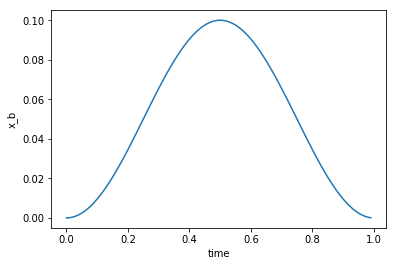

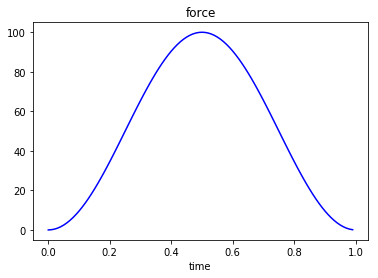

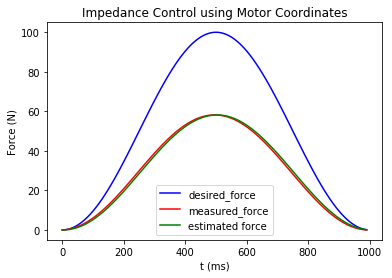

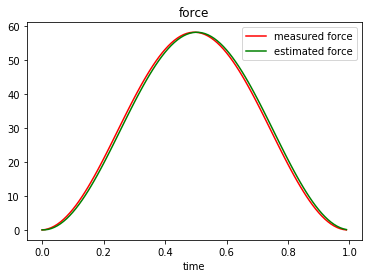

In [55]:
controller_params = dict()
controller_params['k_p'] = 1000
damping_ratio = 0.0
controller_params['k_d'] = 2 * damping_ratio * np.sqrt(controller_params['k_p'])

def impedance_motor_coordinates(freq_hz, save=True, k_s=None):
    params = make_default_params()
    # simulate
    if k_s is not None:
        params['k_s'] = k_s
        
    sys, [A,B,C,D] = impedance_ss_system(params, controller_params)

    


    # simulate
    dt = 0.01/freq_hz
    t_vec = np.arange(0,1.0/freq_hz, dt)
    N = t_vec.size

    omega_vec = 2 * t_vec * np.pi * freq_hz
    amplitude = 0.1  
    x_b = amplitude/2.0 * (1 - np.cos(omega_vec))
    x_b_dot = amplitude/2.0 * np.sin(omega_vec)

    K = np.array([controller_params['k_p'], controller_params['k_d']])
    K = K.reshape(2,1)



    X_b = np.zeros([N,2])
    X_b[:, 0] = x_b
    X_b[:, 1] = x_b_dot

    force_desired = controller_params['k_p']*x_b + controller_params['k_d'] * x_b_dot

    # plot the body position (externally specified)
    plt.plot(t_vec, x_b)
    plt.xlabel('time')
    plt.ylabel('x_b')
    plt.show()

    plt.plot(t_vec, force_desired, 'b')
    plt.title("force")
    plt.xlabel('time')

    plt.show()



    # simulate the system
    t_out, yout, xout = scipy.signal.lsim(sys, x_b, t_vec)
    motor_torque = np.dot(xout, -K)

    plt.plot(1e3*t_vec, force_desired, 'b', label='desired_force')
    plt.ylabel("Force (N)")
    plt.xlabel('t (ms)')
    plt.title("Impedance Control using Motor Coordinates")
    
    plt.plot(1e3*t_out, yout, 'r', label='measured_force')
    plt.plot(1e3*t_out, motor_torque, 'g', label='estimated force')
    plt.legend()
    
    if save:
        plt.savefig(os.path.join(SAVE_DIR, "impedance_control_motor_coords.pdf"))
    plt.show()



    # Force Plots
    # plt.plot(t_vec, force_desired, 'b', label='desired force')
    plt.title("force")
    plt.xlabel('time')
    plt.plot(t_out, yout, 'r', label='measured force')
    plt.plot(t_out, motor_torque, 'g', label='estimated force')
    plt.legend()
    plt.show()
    
    d = dict()
    d['t_vec'] = t_vec
    d['yout'] = yout
    d['motor_torque'] = motor_torque
    d['force_desired'] = force_desired
    return d
    

d = impedance_motor_coordinates(1, save=False)


## Impedance Controller Leg Coordinates

J 0.039125858


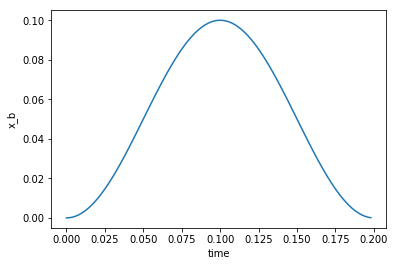

motor_torque.shape (100, 1)


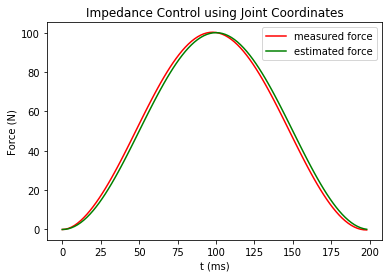

In [53]:

def impedance_leg_coordinates(freq_hz, save=True, k_s=None):
    k_p = controller_params['k_p']

    params = make_default_params()
    # params['k_s'] = 30
    # params['k_s'] = 100

    # params['k_s'] = 10000 # increased stiffness
    # params['k_s'] = 1000

    print "J", params['J']
    # params['J'] = params['J']/10.0
    
    
    if k_s is not None:
        params['k_s'] = k_s


    # simulate
    dt = 0.01/freq_hz
    t_vec = np.arange(0,1.0/freq_hz, dt)
    N = t_vec.size
    omega_vec = 2 * t_vec * np.pi * freq_hz
    amplitude = 0.1  
    x_b = amplitude/2.0 * (1 - np.cos(omega_vec))
    x_b_dot = amplitude/2.0 * np.sin(omega_vec)

    X_b = np.zeros([N,2])
    X_b[:, 0] = x_b
    X_b[:, 1] = x_b_dot

    force_desired = controller_params['k_p']*x_b + controller_params['k_d'] * x_b_dot

    # plot the body position (externally specified)
    plt.plot(t_vec, x_b)
    plt.xlabel('time')
    plt.ylabel('x_b')
    plt.show()

    # plt.plot(t_vec, force_desired, 'b')
    # plt.title("force")
    # plt.xlabel('time')
    # plt.show()


    K = np.array([controller_params['k_p'], controller_params['k_d']])
    K = K.reshape(2,1)
    motor_torque = np.dot(X_b, K)
    print "motor_torque.shape", motor_torque.shape

    input_tape = np.zeros([N,2])
    input_tape[:, 0] = motor_torque.reshape(N)
    input_tape[:, 1] = x_b

    # construct the system
    sys, [A,B,C,D] = linear_system_ss_from_params(params)


    # # simulate the system
    t_out, yout, xout = scipy.signal.lsim(sys, input_tape, t_vec)

    # C = -np.array([controller_params['k_p'], controller_params['k_d']])
    # C = C.reshape([2,1])

    # U = np.dot(xout, C)


    # # plot of measured vs sensed position

    # plt.plot(t_vec, x_b, 'b', label='measured position')
    # plt.plot(t_vec, -xout[:, 0], 'r', label='estimated position')
    # plt.title("Foot position")
    # plt.show()

    # force_error_from_encoder = (x_b + xout[:, 0])*k_p
    # plt.plot(t_vec, force_error_from_encoder, 'b')
    # plt.title('Force Error')
    # plt.show()

    # Force Plots
#     plt.plot(t_out, force_desired, 'b', label='desired force')
    plt.ylabel("Force (N)")
    plt.xlabel('t (ms)')
    plt.title("Impedance Control using Joint Coordinates")
    plt.plot(1e3*t_out, yout, 'r', label='measured force')
    plt.plot(1e3*t_out, motor_torque, 'g', label='estimated force')
    plt.legend()
    if save:
        plt.savefig(os.path.join(SAVE_DIR, "impedance_control_joint_coords.pdf"))
    plt.show()


    # # Estimated and measured forces
    # plt.title("force")
    # plt.xlabel('time')
    # plt.plot(t_out, yout, 'r', label='measured force')
    # plt.plot(t_out, force_est, 'g', label='estimated force')
    # plt.legend()
    # plt.show()

    # # Problem is estimated foot position, not torque tracking

    
impedance_leg_coordinates(5)

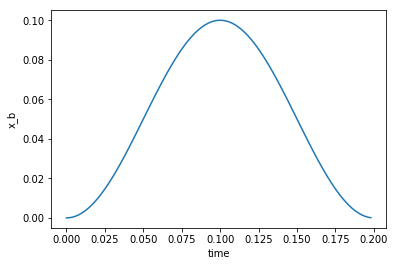

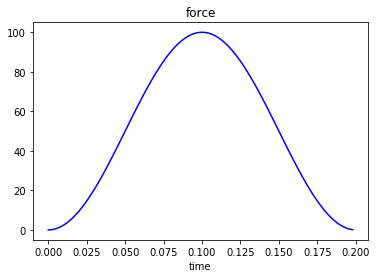

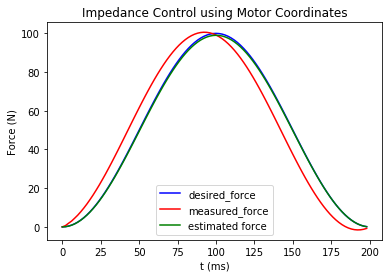

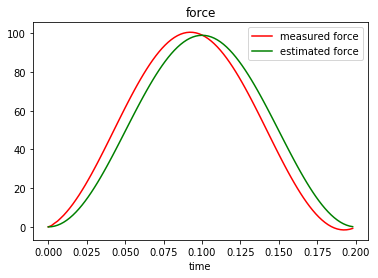

In [54]:
hz = 5
# d = impedance_leg_coordinates(hz, save=False, k_s=None)
d = impedance_motor_coordinates(hz, save=False, k_s=1e5)